## Problem 1.
Using a watershed segmentation, try to segment the image of a brain into the three major tissue types (skin [bright], Cerebal Spinal fluid [dark], and brain).  You will most likely want to use a combination of steps to first segment the whole head from the back ground and then segment the tissue into types.  

Comment out the arrows/text (they are just to show you the tissue types).  Work in gray scale.

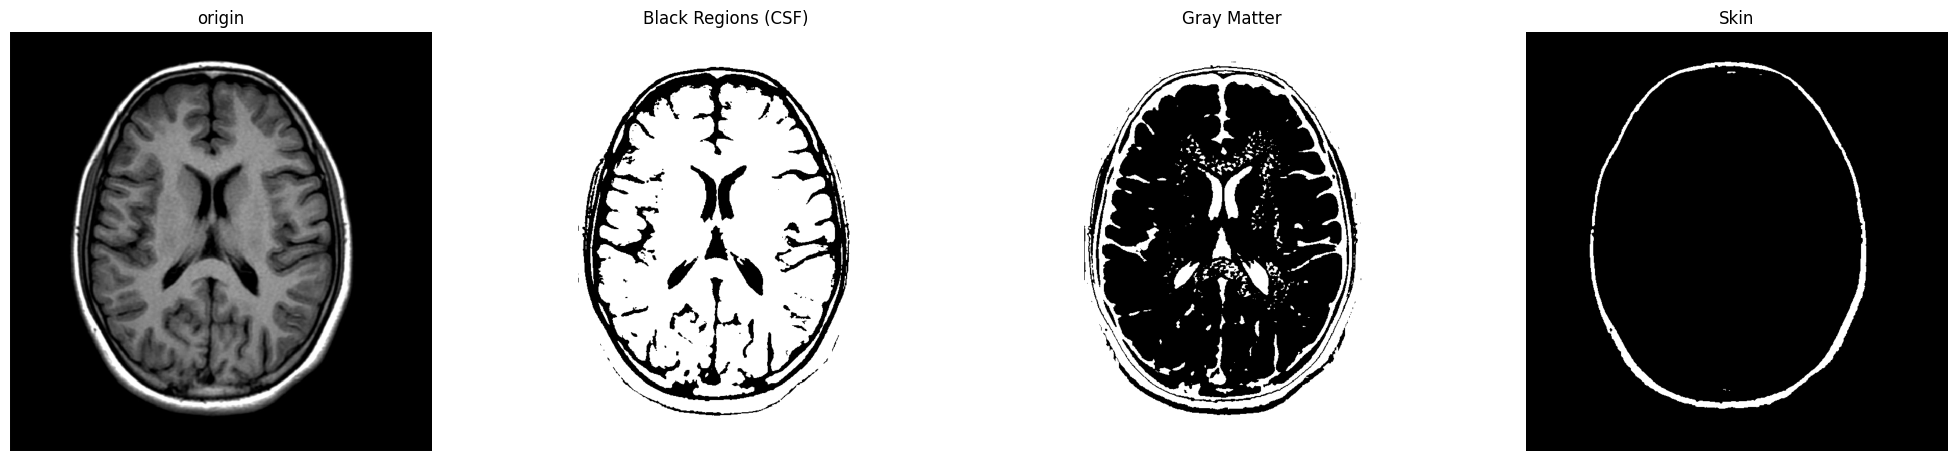

In [112]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

img = cv2.imread(os.path.relpath('data/MRI_brain.png'))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# background region
kernel = np.ones((3, 3), np.uint8)
sure_bg = cv2.dilate(thresh, kernel, iterations=3)

# foreground region
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1
markers[unknown == 255] = 0

#watershed algorithm
img_color = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(img_color, markers)

black_mask = np.full_like(gray, 255)  
black_mask[(markers == 1) & (gray < 60)] = 0  # Black regions (CSF)

gray_mask = np.full_like(gray, 255) 
gray_mask[(markers == 1) & (gray >= 40) & (gray < 150)] = 0  # Gray matter

white_mask = np.zeros_like(gray)  
white_mask[(markers == 1) & (gray >= 170)] = 255  # skin

plt.figure(figsize=(25, 10))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title('origin')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(black_mask, cmap='gray')
plt.title('Black Regions (CSF)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(gray_mask, cmap='gray')
plt.title('Gray Matter')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(white_mask, cmap='gray')
plt.title('Skin')
plt.axis('off')

plt.show()


## Problem 2.
Digital segmentation methods have been widely used in medical pathology to automate methods that used to be done by hand.  One example of this is counting the number of cells in an image.  In this problem, you will use the image of red blood cells.  Design a segmentation approach similar to the demo using contours to attempt to count the number of cells in the image.    


Image credit ShutterStock

Number of detected cells: 186


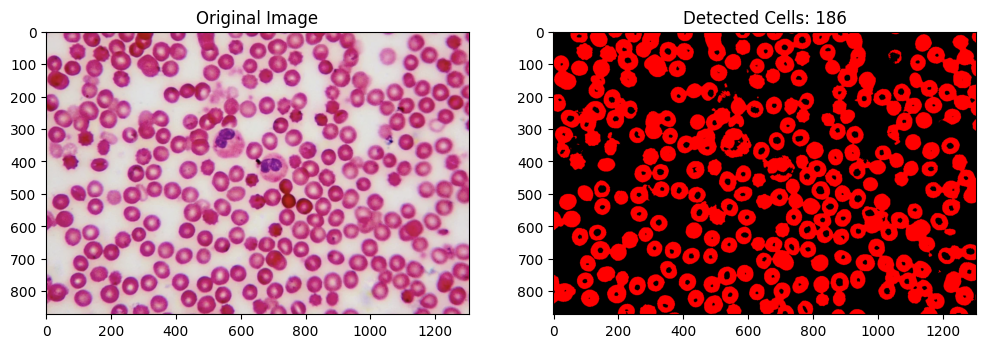

In [183]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread(os.path.relpath('data/CellCounting.png'))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Use connected components to count the connected regions
num_labels, labels_im = cv2.connectedComponents(thresh)

# Display the number of connected regions, representing the detected cells
print(f'Number of detected cells: {num_labels - 1}')  # Subtract background label

output_img = np.zeros_like(img)
output_img[labels_im > 0] = [0, 0, 255] 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Cells: {num_labels - 1}')

plt.show()


## Problem 3
Use the K-means segmetation method based on RGB colors to try to seperate the CitySkyline image into several components.  Play around with the number of clusters and show at least three images with different parameters.


Image source: https://pxhere.com/en/photo/705594 (Image of Minneapolis, MN)


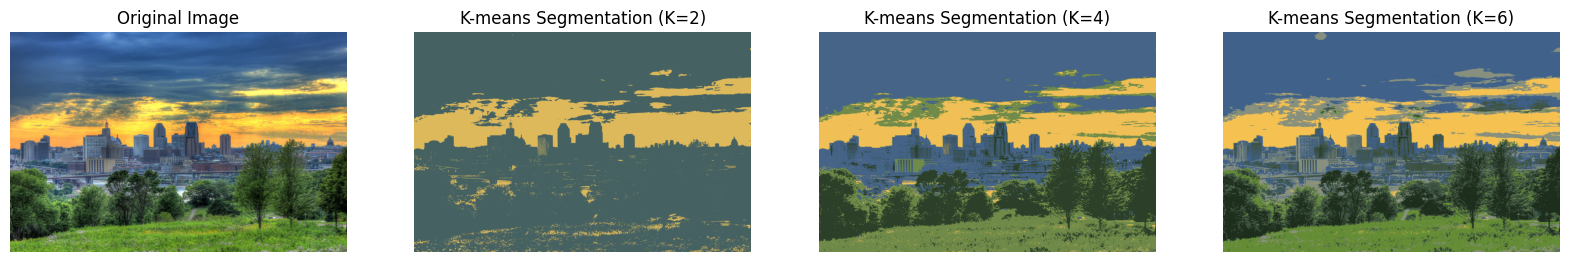

In [7]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread(os.path.relpath('data/CitySkyline.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to a 2D array where each pixel is a data point
pixel_values = img_rgb.reshape((-1, 3))  # Reshape the image into a 2D array
pixel_values = np.float32(pixel_values)  # Convert pixel values to float type


def kmeans_segmentation(img_data, k):
    _, labels, centers = cv2.kmeans(img_data, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2), 10, cv2.KMEANS_RANDOM_CENTERS)
    
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    
    segmented_image = segmented_image.reshape(img.shape)
    
    return segmented_image


clusters = [2, 4, 6]  # Adjust the number of clusters
segmented_images = [kmeans_segmentation(pixel_values, k) for k in clusters]


fig, ax = plt.subplots(1, 4, figsize=(20, 10))


ax[0].imshow(img_rgb)
ax[0].set_title('Original Image')
ax[0].axis('off')

for i, k in enumerate(clusters):
    ax[i+1].imshow(segmented_images[i])
    ax[i+1].set_title(f'K-means Segmentation (K={k})')
    ax[i+1].axis('off')
plt.show()

## Problem 4
Following the example from class of using the openCV BackgroundSubtractor modules with video 
from a web camera, implement a similar while-loop to grab video frames and apply the background subtraction  method to 
mask the video.

* Demonstrate the use of the three versions of this method in openCV    

*       cv2.createBackgroundSubtractorMOG()
*       cv2.createBackgroundSubtractorMOG2()
*       cv2.createBackgroundSubtractorGMG()

For ECE2390 students

* Examine how at least two of the parameters (such as number of gaussian clusters or the 'history' parameter ).  
Note your observations in comments in the code.



In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# MOG: Background subtractor based on Gaussian mixture model, 
# the default Gaussian cluster is 3 to 5
bg_subtractor_mog = cv2.bgsegm.createBackgroundSubtractorMOG()  

# 2. 2. MOG2: The second model is a background subtractor, 
# which also supports some unique parameters and is more suitable for more 
# complex foregrounds. history=200: This value is how many frames of background 
# the model remembers. If this value is set too large, the background is not easily 
# updated, so that the dynamically changing parts are easily misjudged as background.
#  varThreshold=50: This value is used to control the difference sensitivity of pixels
#  from background to foreground. The smaller the value, the easier it is for 
# background updates to count dynamic ones as foreground.
bg_subtractor_mog2 = cv2.createBackgroundSubtractorMOG2(history=200, varThreshold=50)

# 3. GMG: This model is older and uses Bayesian probability and some 
# statistical methods. initializationFrames=20: Initialize the background model
# within the first 20 frames. The more frames initialized, the more stable the 
# background model will be, but the initialization time will also be longer. 
# decisionThreshold=0.7: Controls the strictness of foreground judgment. 
# The larger the value, the stricter it is and the easier it is to miss detection. 
# The smaller the value, the more sensitive the foreground judgment is and
#  the more noise may be generated.
bg_subtractor_gmg = cv2.bgsegm.createBackgroundSubtractorGMG(initializationFrames=20, decisionThreshold=0.7)

kernel = np.ones((3, 3), np.uint8)
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)  

    fgmask_mog = bg_subtractor_mog.apply(frame)
    fgmask_mog2 = bg_subtractor_mog2.apply(frame)
    fgmask_gmg = bg_subtractor_gmg.apply(frame)

    fgmask_mog = cv2.morphologyEx(fgmask_mog, cv2.MORPH_CLOSE, kernel)
    fgmask_mog2 = cv2.morphologyEx(fgmask_mog2, cv2.MORPH_CLOSE, kernel)
    fgmask_gmg = cv2.morphologyEx(fgmask_gmg, cv2.MORPH_CLOSE, kernel)

    cv2.imshow('Original Frame', frame)
    cv2.imshow('MOG Background Subtraction', fgmask_mog)
    cv2.imshow('MOG2 Background Subtraction', fgmask_mog2)
    cv2.imshow('GMG Background Subtraction', fgmask_gmg)

    key = cv2.waitKey(30)
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()
